# Introduction

Given the following tasks:

- For each frame of an input video, the system needs to detect and display objects not belonging to the background scene and produce a textual output listing the found blobs and their meaningful features.
- The system is required to discriminate between a present blob and a false one originated by the removal of an object from the background reference.

The proposed solution implements the developed library `intrusiondetection`, this notebook shows the step-by-step operations computed to achieve the final outputs displaying the computations on some key frames alongside considerations over the made choices. 

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

from intrusiondetection.parameters import ParameterList, ParameterSet
from intrusiondetection.utility import distance_euclidean, subplot_images, subplot_images_frames, subplot_morphology_steps
from intrusiondetection.morphology import MorphOp, MorphOpsSet
from intrusiondetection.video import Video 
from intrusiondetection.displayable import Background
from intrusiondetection.enum import BackgroundMethod
from intrusiondetection.presets import default_preset
from intrusiondetection.enum import ParameterPreset

%matplotlib inline 

input_video_path = "input.avi"
video = Video(input_video_path)

key_frame_indexes = [124, 164, 301]
key_frames = [video.frames[frame_index] for frame_index in key_frame_indexes]

## Considerations

Video characteristics:

- 12 fps
- ~41s
- 320x240 pixels
- 8 bit/pixel (256 gray levels)

Observed details:

- There is a meaningful amount of noise present.
- The lighting condition in the scene changes slightly.
- The person changes its moving velocity in the course of the video.

# Background Estimation

## Initial Background

To estimate a good background for the scene, it's necessary to perform an interpolation between some chosen frames of the video, the parameters of the operation are:

- The interpolation function used, the methods took in consideration are `np.mean` and `np.median`.
- The amount of initial frames, which is tuned based on a tradeoff between the smallest and most stable number. Therefore, the considered values are `40`, `80`, `120`

By performing various tests, it has been noticed that the output doesn't result in a significant change of quality by increasing the value over 80 frames, on the other hand, by decreasing the value under 80, the resulting image looks unclear using both functions.

It has also been observed that the `np.median` function achieves more stable solutions.

The chosen values are `80` frames using the `np.median` interpolation.

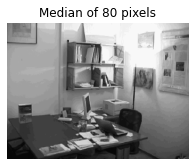

In [2]:
initial_background = Background(input_video_path, np.median, 80)
initial_background.display('image', title='Median of 80 pixels')

## Background update
The two main approaches to obtain a dynamic background are `blind` and `selective`.

The following section shows an example of a blind background computed using an adaption rate of `0.3`.

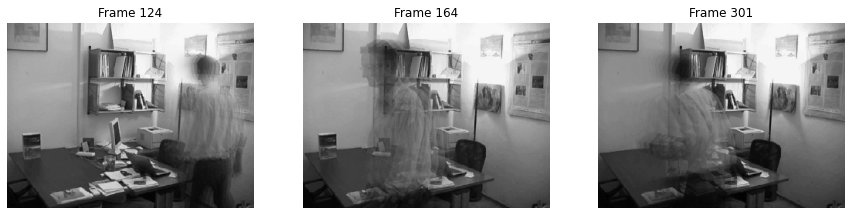

In [3]:
background_alpha = 0.3

blind_backgrounds = video.process_backgrounds(BackgroundMethod.BLIND, initial_background, background_alpha)
key_frame_backgrounds = [blind_backgrounds[key_frame_index] for key_frame_index in key_frame_indexes]

subplot_images_frames(key_frame_backgrounds, key_frame_indexes, 'image', "Frame")

For the selective approach, a threshold and a distance function have to be used to compute the subtraction between the frame and the background.

As a further improvement, some binary morphology operators are applied to obtain a more meaningful background mask:

- 3x3 Opening: Denoising of the subtraction
- 50x50 Closing: Filling of any potential holes
- 15x15 Dilation: Achievement of a mask big enough to contain the detected objects and their position after any movement

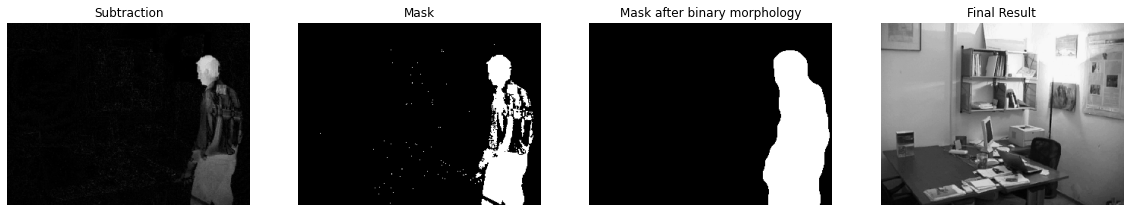

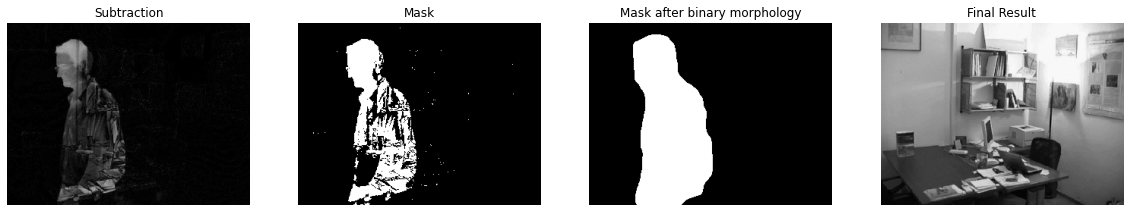

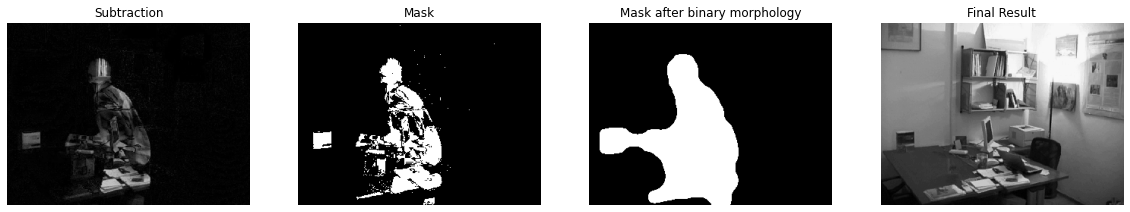

In [4]:
background_threshold = 30
background_distance = distance_euclidean

selective_backgrounds = video.process_backgrounds(
    BackgroundMethod.SELECTIVE, initial_background, background_alpha, background_threshold, background_distance, 
    MorphOpsSet(
        MorphOp(cv2.MORPH_OPEN, (3,3)), 
        MorphOp(cv2.MORPH_CLOSE, (50,50), cv2.MORPH_ELLIPSE), 
        MorphOp(cv2.MORPH_DILATE, (15,15), cv2.MORPH_ELLIPSE)
    )
)
key_frame_backgrounds = [selective_backgrounds[key_frame_index] for key_frame_index in key_frame_indexes]

for key_frame_background in key_frame_backgrounds:
    key_frame_background.display_row([
        {'key': 'subtraction', 'title': 'Subtraction'},
        {'key': 'mask_raw', 'title': 'Mask'},
        {'key': 'mask_refined', 'title': 'Mask after binary morphology'},
        {'key': 'image', 'title': 'Final Result'},
    ])

A selective background clearly obtains better results, it is therefore the chosen method.

# Change Detection

## Background Subtraction

To perform the actual change detection the first step is to subtract the current frame with respect to the corresponding background:

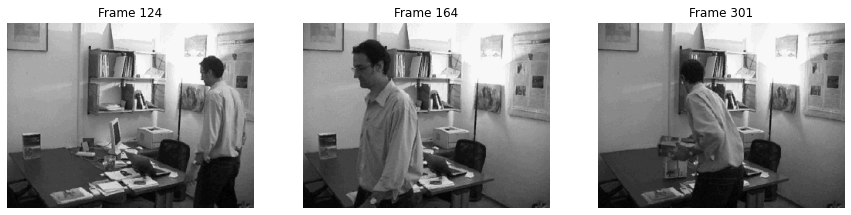

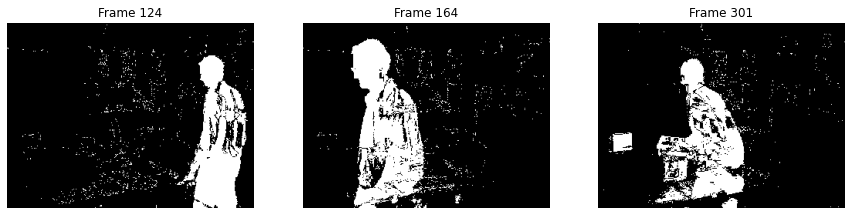

In [5]:
threshold = 15
distance_function = distance_euclidean

for key_frame_index, key_frame in zip(key_frame_indexes, key_frames):
    key_frame.apply_change_detection(selective_backgrounds[key_frame_index], threshold, distance_function)

subplot_images_frames(key_frames, key_frame_indexes, ['image', 'mask_raw'], "Frame")

## Binary Morphology

Thanks to the selective background update, the resulting mask doesn't show a big amount of noise, a series of binary morphology operators is applied to improve furthermore the result:

- 3x3 Rectangular Opening: Removal of the majority of the noise
- 50x50 Closing: Execution of holes filling
- 10x10 Opening: Deletion of small blobs due to the remaining noise

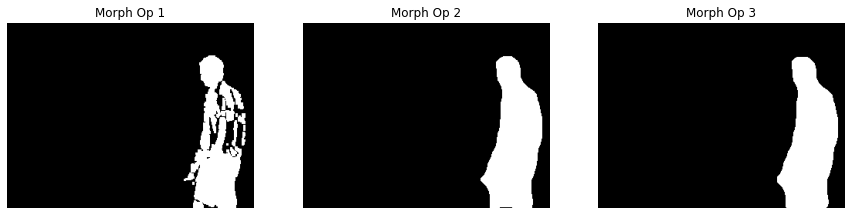

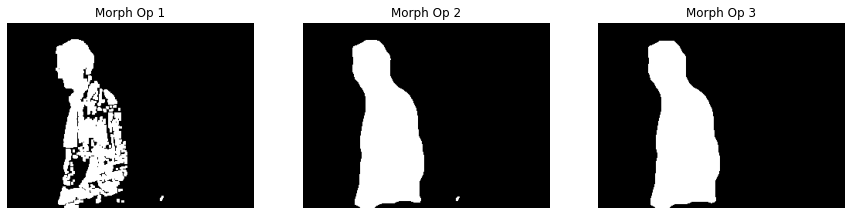

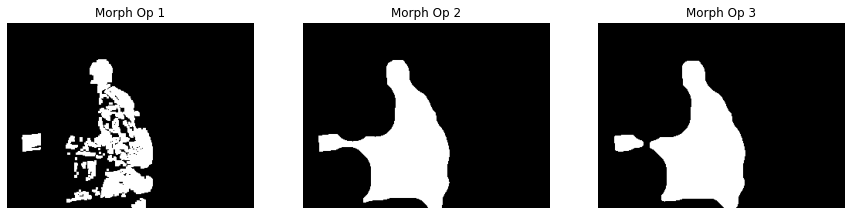

In [6]:
morph_ops = [
    MorphOp(cv2.MORPH_OPEN, (3,3)),
    MorphOp(cv2.MORPH_CLOSE, (50, 50), cv2.MORPH_ELLIPSE),
    MorphOp(cv2.MORPH_OPEN, (10,10), cv2.MORPH_ELLIPSE),
]

for key_frame in key_frames:
    subplot_morphology_steps(key_frame, morph_ops)
    key_frame.apply_morphology_operators(MorphOpsSet(*morph_ops))

# Blob Analysis

## Blob Labeling

The labeling of the obtained image is performed using the `cv2.connectedComponents` function.

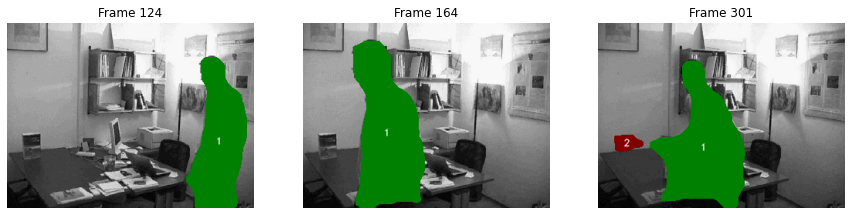

In [7]:
for key_frame in key_frames:
    key_frame.apply_blob_labeling(create_output=True)

subplot_images_frames(key_frames, key_frame_indexes, 'blobs_labeled', 'Frame')

## Selected Features

The considered features are:

- Area
- Perimeter
- Barycentre

## Label Remapping
To keep the IDs assignment consistent during the whole process and assure uniqueness it is necessary to keep continuity between the blob labeling in subsequential frames, therefore, a similarity function is computed to seek for correspondances between the current and previous blobs.

The IDs are then assigned by matching the ones in the previous frame.
The blobs are displayed with their ID printed on the barycentre.

Given the area of the two objects $A_1, A_2$, their barycentres $(x_1, y_1), (x_2, y_2)$, the total area of the frame $A_F$ and its diagonal $d_F$ the similarity function is defined as:


$$1-\frac{\frac{|A_1-A_2|}{A_F}+\frac{\sqrt{(x_1-x_2)^2+(y_1-y_2)^2}}{d_F}}{2}$$

A threshold parameter is then applied to define a lower bound for a minimum similarity below which two blobs are always considered different.

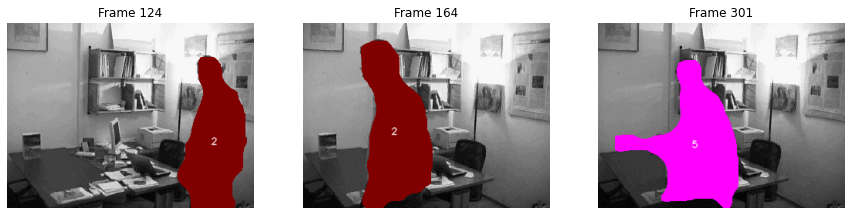

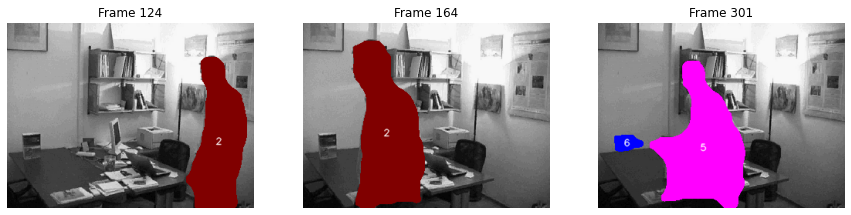

In [8]:
similarity_threshold = 80

video_copy = Video(input_video_path)
#Computes the whole intrusion detection algorithm at once to get the real assigned IDs
video_copy.intrusion_detection(ParameterSet(tuning_params=default_preset(ParameterPreset.SLOW)), initial_background)
key_frame_prevs = []

for key_frame, key_frame_index in zip(key_frames, key_frame_indexes):
    key_frame_prev = video_copy.frames[key_frame_index - 1]
    
    key_frame.apply_blob_remapping(key_frame_prev.blobs, similarity_threshold, base_id=key_frame_prev.max_blob_id, create_output=True)
    key_frame_prevs.append(key_frame_prev)

subplot_images_frames(key_frame_prevs, key_frame_indexes, 'blobs_remapped', "Frame")
subplot_images_frames(key_frames, key_frame_indexes, 'blobs_remapped', "Frame")

## Classification 
To classify the blobs as `person` or `object`, a `classification_score` is computed. The value is based on their area by normalizing it with respect to the total number of pixels in the frame.

After some analysis of the video, the chosen threshold for the classification is `2.6`.

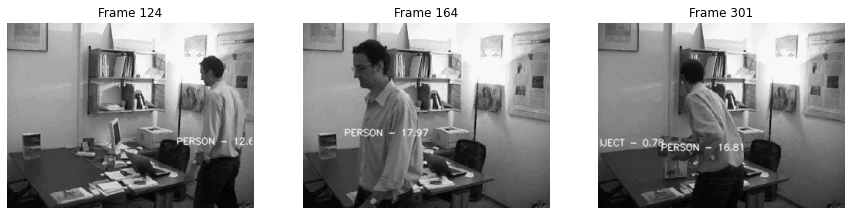

In [9]:
classification_threshold = 2.6

for key_frame in key_frames:
    key_frame.apply_classification(classification_threshold, create_output=True)

subplot_images_frames(key_frames, key_frame_indexes, 'blobs_classified', 'Frame')

# True/False Object Recognition

To detect whether an object is effectively present or not, the selected approach is the evaluation of the edge strength, such that, when the contours of a found blob presents sharp edges in the original image, it is considered to be present, otherwise it is labeled as fake.

The computation is performed by using a Sobel operator returning a smoothed edge score, not taking into account the large amount of noise present in the original frame. 

Given the fact that in the majority of the situations, the presence/absence of the object is continuous between contiguous frames, it has been chosen to use a value obtained by computing a weighted sum between the current edge score and the score of the correspondent object in the precedent frame.

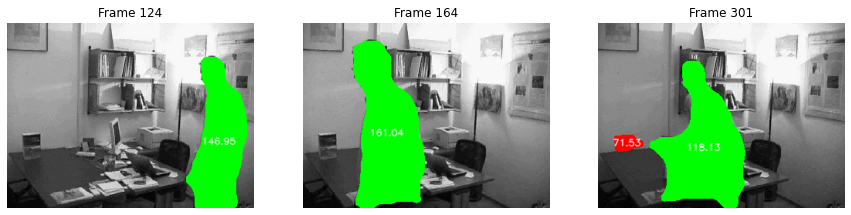

In [10]:
edge_threshold = 92
edge_adaptation = 0.1

for key_frame in key_frames:
    key_frame.apply_object_recognition(edge_threshold, edge_adaptation, create_output=True)

subplot_images_frames(key_frames, key_frame_indexes, 'blobs_detected', 'Frame')

# Conclusion

## Text Output Generation

A CSV file is then generated, for each frame the following informations are stored:

- Frame Index
- Number of Detected Objects
- A row for each detected object containing:
   - Object Identifier
   - Area
   - Perimeter
   - Barycentre (x coordinate)
   - Barycentre (y coordinate)
   - Classification Score
   - Edge Score
   - Object Presence [True / False] 
   - Classification

## Video Output Generation

The graphical output shows the contours of the found objects, the color of the contour depends on the object classification:

- Person: Green
- True Object: Blue
- Fake Object: Red

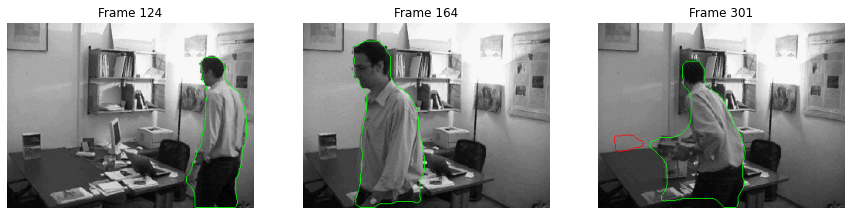

In [11]:
for key_frame in key_frames:
    key_frame.generate_graphical_output()

subplot_images_frames(key_frames, key_frame_indexes, 'image_output', 'Frame')

## Execution Time

To improve the execution time a series of different presets have been provided to allow adjustment of the tradeoff between precision and execution time.

The only main difference consists in the usage of rectangular structuring elements instead of elliptical ones in the binary morphology step. While reducing the correctness of the final shapes the time of the execution drops significantly.

| Preset | Max Time (per frame) | Min Time (per frame) | Avg Time (per frame) |
| --- | --- | --- | --- |
| 1 (SLOW) | 134ms | 44ms | 60ms |
| 2 (MEDIUM) | 35ms | 24ms | 30ms |
| 3 (FAST) | 17ms | 5ms | 9ms |

In this notebook, the preset `1` was used, but for example, by using the preset `3`, an average time of 9ms allows the algorithm to be performed online with a relatively high frame rate.

## Usage

`python main.py [-h/--help] [-I/--input INPUT] [-o/--output OUTPUT_DIRECTORY] [-S/--stats] [-T/--tuning] [-P/--preset PRESET]`

- `--help`: Display help message
- `--input`: Input video used to compute the intrusion detection algorithm
- `--ouput`: Output directory where the requested output are stored
- `--stats`: Compute and print additional info on the elaborated data
- `--tuning`: Activates tuning mode, in which all the algorithm steps are generated as output videos
- `--preset`: Preset of parameters used from most accurate (1) to fastest (3)